## Imports

In [1]:
import numpy as np
import torch
import os
import itertools

from matplotlib import pyplot as plt
from time import gmtime, strftime

from utils.image_helpers import plot_image_grid, get_images
from simulation.SimulationPipeline import SimulationPipeline
from utils.configuration_helpers import ModelFittingConfiguration
from fitting.Fitter import fit_model

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


# Setup

In [2]:
number_of_images = 20
image_path = 'data/imagenet_v2_top_images'
image_dimensions = [100, 100 , 1]

k_factor = 0.15
pf_factor = 1.0
snr = 32

model_types = ['deep']
input_shapes = [[12, 12], [14, 14]]
numbers_of_layers = [4, 6]
numbers_of_hidden_channels = [40, 48]

# Load Image

10000  images found in  data/imagenet_v2_top_images


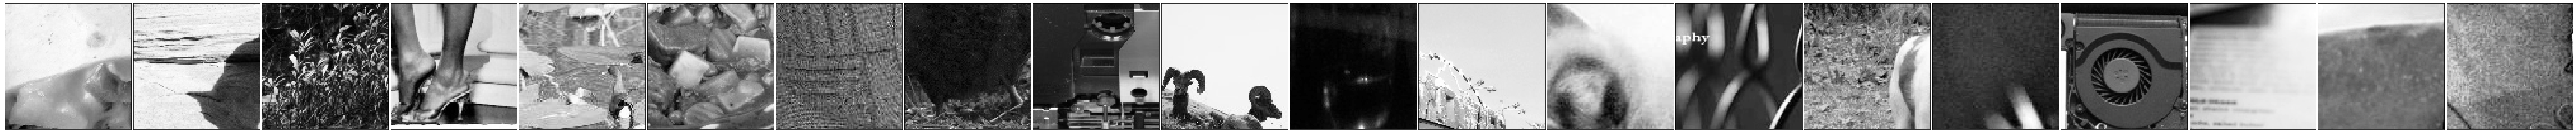

In [3]:
target_images = get_images(image_path, number_of_images, image_dimensions[0])
plot_image_grid(target_images, ncols = number_of_images)
plt.show()

# Gibbs & Noise Simulation

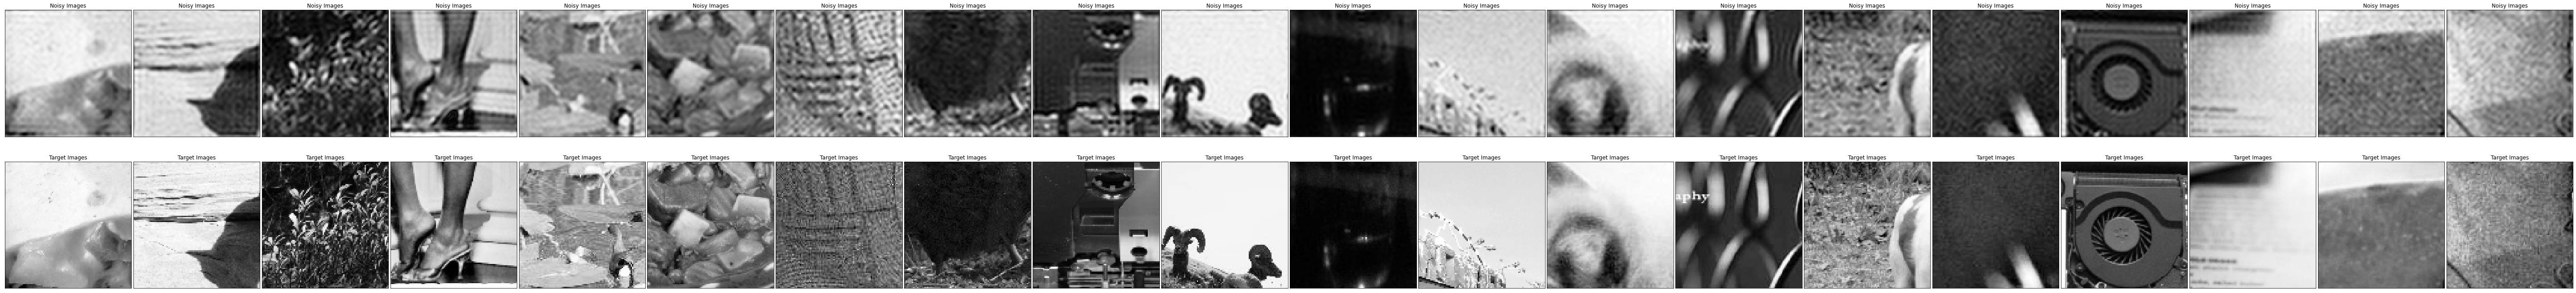

In [4]:
pipeline = SimulationPipeline(k_factor=k_factor, pf_factor=pf_factor, snr=snr)
noisy_images = pipeline.simulate_list(target_images)

images_to_display = noisy_images + target_images
titles = ['Noisy Images'] * len(noisy_images) + ['Target Images'] * len(target_images)
plot_image_grid(images_to_display, titles, ncols=number_of_images)
plt.show()

# Fit all parameter combinations and save results

In [5]:
config = ModelFittingConfiguration()
config.image_dimensions = image_dimensions
config.number_of_layers = None
config.number_of_hidden_channels = None
config.model_type = None
config.input_shape = None
print(config)

gridsearch_path = 'data/gridsearches/' + strftime("%Y-%m-%d-%H:%M", gmtime())
print(gridsearch_path)

parameter_combinations = list(itertools.product(model_types, 
                                                input_shapes, 
                                                numbers_of_layers, 
                                                numbers_of_hidden_channels))

noisy_path = gridsearch_path + '/noisy/'
target_path = gridsearch_path + '/target/'
os.makedirs(noisy_path)
os.makedirs(target_path)

image_dimensions: [100, 100, 1]  
result_path: data/results  
model_type: None  
input_shape: None  
number_of_layers: None  
number_of_hidden_channels: None  
number_of_iterations: 3000  
number_of_runs: 10  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  

data/gridsearches/2021-01-11-10:16


In [6]:
def generate_path(parameter_combination, gridsearch_path):
    path = gridsearch_path
    path += '/' + str(parameter_combination[0])
    path += '/' + str(parameter_combination[1])
    path += '/' + str(parameter_combination[2])
    path += '/' + str(parameter_combination[3])
    path += '/'
    return path

def update_config(config, parameter_combination, gridsearch_path):
    config.model_type = parameter_combination[0]
    config.input_shape = parameter_combination[1]
    config.number_of_layers = parameter_combination[2]
    config.number_of_hidden_channels = parameter_combination[3]
    config.result_path = generate_path(parameter_combination, gridsearch_path)
    return config

In [ ]:
for image_index, (noisy_image, target_image) in enumerate(zip(noisy_images, target_images)):
    plt.imsave(noisy_path + str(image_index) +'.png', noisy_image[:,:,0], cmap='gray')
    plt.imsave(target_path + str(image_index) +'.png', target_image[:,:,0], cmap='gray')
    for param_index, parameter_combination in enumerate(parameter_combinations):
        config = update_config(config, parameter_combination, gridsearch_path)
        log_prefix = f'Image: {image_index+1}/{len(noisy_images)}, '
        log_prefix += f'Parameters: {param_index+1}/{len(parameter_combinations)}, '
        filename = str(image_index) + '.png'
        model_image = fit_model(noisy_image, config, log_prefix, filename)